In [318]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from smart_mobility_utilities.common import random_tour
import osmnx as ox

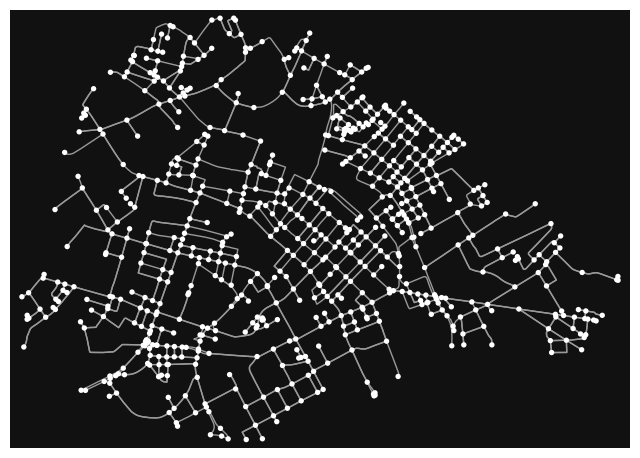

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [319]:
G = ox.graph_from_place('City Centre, Manchester, UK', network_type='drive', retain_all=False)
ox.plot_graph(G)



In [320]:
def cost_tour(G, tour):
    cost = 0
    for u,v in zip(tour, tour[1:]):
        path = nx.shortest_path(G, u,v, weight='length')
        weight = nx.path_weight(G,path, weight="length")
        cost += weight
        last_node = tour[len(tour) - 1]
        first_node = tour[0]
        path1 = nx.shortest_path(G, first_node,last_node, weight='length')
        weight1 = nx.path_weight(G,path1, weight="length")
        cost += weight1
       
    return cost

In [322]:
def PMX_crossover(firstPermutation, secondPermutation):
    # we need to know the length of either permutation
    # they must be equal in size
    length = len(firstPermutation)
    
    # (1) choosing the two crossover points
    #     by randomly select a point from the
    #     first half and another point from the second half
    first_Cross = random.randint(0, length // 2)
    second_Cross = random.randint(length // 2 + 1, length - 1) + 1
    
    # (2) initializing the two equal sized segments
    #     and create another array with the same size of 
    #     any permutation to be the child
    child = [None] * length
    subP1 = firstPermutation[first_Cross:second_Cross]
    subP2 = secondPermutation[first_Cross:second_Cross]
    
    # (3) copy the elements in the segment from the first permutation
    #    into the same segment in the child
    child[first_Cross:second_Cross] = subP1
    
    # (4) finding common elements in the segment from the
    #     the first permutation and the second permutation
    #     and get its mirror from first permutation to second
    pairs = list()
    for element in subP2:
        if element not in subP1:
            pairs.append((element, subP1[subP2.index(element)]))
    
    # (5) copying into the child all the elements in the segment
    #.    that are present in the first permutation segment but
    #.    aren't present in the second permutation segment.
    #.    if not we need to copy that element in place outside
    #     the segment in a place where we are sure that would
    #.    result into inadmissible permutations.
    for pair in pairs:
        second = pair[1]
        if second not in subP2:
            index = secondPermutation.index(second)
            child[index] = pair[0]
        else:
            # when there is an element from the segment of the first
            # permutation in the segment of the second permutation 
            reflect = firstPermutation[secondPermutation.index(second)]
            
            # bouncing back and forth between the two arrays indices
            # to get out of second permutation segment
            while reflect in subP2:
                bounce = reflect
                reflect = firstPermutation[secondPermutation.index(bounce)]
            child[secondPermutation.index(reflect)] = pair[0]
    
    # (6) go through all the elements that have not been assigned
    #     yet in the child array and assign them with the second permutation
    #     elements
    for i in range(length):
        if child[i] == None:
            child[i] = secondPermutation[i]
    return child

In [323]:
def insert_mutation(permutation):
    # copying the list so we don't mess with the original
    child = permutation[:]
    
    # choose two random genes and make sure that they are different
    first_gene = random.choice(child)
    second_gene = random.choice(child)
    while first_gene == second_gene:
        first_gene = random.choice(child)
        second_gene = random.choice(child)
    
    # removing the second gene from the list and insert it just after the first
    child.remove(second_gene)
    geneNewIndex = child.index(first_gene) + 1
    child.insert(geneNewIndex, second_gene)
    return child

In [324]:
picadilly = ox.distance.nearest_nodes(G,-2.2312,53.4774)
oxford = ox.distance.nearest_nodes(G,-2.2422,53.4741)
library = ox.distance.nearest_nodes(G,-2.244666,53.478062)
MOSI = ox.distance.nearest_nodes(G,-2.25333232,53.472831442)

all_nodes = [picadilly,oxford,library,MOSI]
print(all_nodes)

[347454437, 30891675, 4833840, 5774104183]


In [325]:
# remember that ERO takes the graph as input
# not like PMX or Order 1
crossover = PMX_crossover
mutate = insert_mutation

size_of_population = 5
ngen = 1000
best_at_gen = [] # for keeping track of the best tour at a given generation

# Initialize population
#pool = [*random_tour(G.nodes, number_of_perms=size_of_population)]
#print(pool)
pool = [*random_tour(all_nodes, number_of_perms=size_of_population)]
print(pool)

[[30891675, 347454437, 4833840, 5774104183], [4833840, 347454437, 30891675, 5774104183], [30891675, 5774104183, 4833840, 347454437], [5774104183, 4833840, 30891675, 347454437], [30891675, 5774104183, 347454437, 4833840]]


In [326]:
for generation in tqdm(range(ngen)):
    # 1- crossover every consecutive pair of routes
    # 2- replace the weakest of the two parent with the product of the crossover
    # 3- mutate the whole pool
    # 4- repeat and save the value best tour in that generation
    
    # 1-
    for parent1, parent2 in zip(pool, pool[1:]):
        child = crossover(parent1, parent2)
        
        # 2-
        if cost_tour(G, parent1) > cost_tour(G, parent2):
            pool[pool.index(parent2)] = child
        else:
            pool[pool.index(parent1)] = child
    
    # 3-
    for i in range(size_of_population):
        pool[i] = mutate(pool[i])
    
    # 4-
    best_at_gen.append(cost_tour(G, min(pool, key = lambda tour : cost_tour(G, tour))))

tour = min(pool, key = lambda route : cost_tour(G, route)) # result
tour_cost = cost_tour(G, tour) #result cost
print(all_nodes)
print(cost_tour(G,all_nodes))
print (tour)
print(tour_cost)

  0%|          | 0/1000 [00:00<?, ?it/s]

[347454437, 30891675, 4833840, 5774104183]
7847.370000000001
[5774104183, 30891675, 347454437, 4833840]
6064.275000000001


[5774104183, 30891675, 347454437, 4833840]


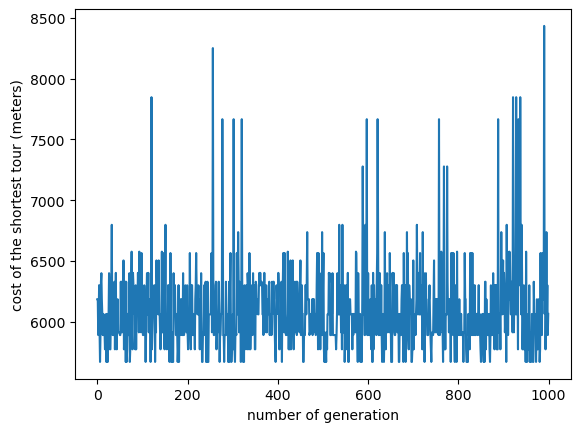

In [327]:
tour = min(pool, key = lambda route : cost_tour(G, route)) # result
tour_cost = cost_tour(G, tour) #result cost
print (tour)
plt.xlabel("number of generation")
plt.ylabel("cost of the shortest tour (meters)")
plt.plot(best_at_gen)
plt.show()

In [328]:
def full_path(G, tour):
    path_1 = []
   
    for u,v in zip(tour, tour[1:]):
         path = nx.shortest_path(G, u,v, weight='length')
         path_1.append(path)

    path2 = nx.shortest_path(G, tour[-1],tour[0], weight='length')
    path_1.append(path2)
    return path_1

In [329]:

def get_center(G):
    undir = G.to_undirected()
    length_func = nx.single_source_dijkstra_path_length
    sp = {source: dict(length_func(undir, source, weight="length")) for source in G.nodes}
    eccentricity = nx.eccentricity(undir,sp=sp)
    center_osmid = nx.center(undir,e=eccentricity)[0]
    return center_osmid

In [330]:
fullPath = full_path(G,tour)
import ipyleaflet as lf
import folium as fl
zoom = 15
force_leaflet=False

route = fullPath[0]

center_osmid = get_center(G)
G_gdfs = ox.graph_to_gdfs(G)
nodes_frame = G_gdfs[0]
ways_frame = G_gdfs[1]

center_node = nodes_frame.loc[center_osmid]
location = (center_node['y'], center_node['x'])

m = lf.Map(center = location, zoom = zoom)


for item in fullPath:
    route = item
    start_node = nodes_frame.loc[route[0]]
    end_node = nodes_frame.loc[route[len(route)-1]]

    start_xy = (start_node['y'], start_node['x'])
    end_xy = (end_node['y'], end_node['x'])


    if len(route) >= 500 and not force_leaflet:
        print(f"The route has {len(G)} elements, using folium to improve performance.")
        m = ox.plot_route_folium(G = G, route = route, zoom= zoom, color='red')
        fl.Marker(location=start_xy).add_to(m)
        fl.Marker(location=end_xy).add_to(m)
       
    marker = lf.Marker(location = start_xy, draggable = False)
    m.add_layer(marker)
    marker = lf.Marker(location = end_xy, draggable = False)
    m.add_layer(marker)

    for u, v in zip(route[0:], route[1:]):
        
        try:
            geo = (ways_frame.query(f'u == {u} and v == {v}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        except:
            geo = (ways_frame.query(f'u == {v} and v == {u}').to_dict('list')['geometry'])
            m_geo = min(geo,key=lambda x:x.length)
        x, y = m_geo.coords.xy
        points = map(list, [*zip([*y],[*x])])
        ant_path = lf.AntPath(
            locations = [*points], 
            dash_array=[1, 10],
            delay=1000,
            color='red',
            pulse_color='black'
        )
        m.add_layer(ant_path)

 
m

Map(center=[53.4778068, -2.2406367], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…